## Introduction to AdventureWorks2022

AdventureWorks is a fictional company that makes and sells bicycles and related accessories. The company operates in different areas like human resources, production, sales and customer management. Their database contains detailed information about employees, products, orders, and customers. The product range mainly includes bikes, bike parts and accessories, showing that the company offers a wide variety for different customers segments. The database contains detailed employee data, a large product selection and tracks sales over time. 

In [130]:
from sqlalchemy import create_engine, inspect
from scipy import stats 
import numpy as np                                             
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
# Create database engine 
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # SQL Server authentication  
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    return create_engine(eng)     
 
engine = new_engine("mssql", "DESKTOP-B3C6BEO", "AdventureWorks2022", integrated_security=True)
connection = engine.connect()


## Exploring Database Structure


In [132]:
# Inspect database schemas and count tables (skip dbo)
inspector = inspect(engine)
all_schemas = inspector.get_schema_names()
schema_table_counts = []

for schema in all_schemas:
    if schema == 'dbo':  
        continue
    tables = inspector.get_table_names(schema=schema)
    schema_table_counts.append({
        'Schema': schema,
        'Number of Tables': len(tables),
        'Has Tables': len(tables) > 0
    })

df_schema_counts = pd.DataFrame(schema_table_counts).sort_values(by='Number of Tables', ascending=False)
df_schemas_with_tables = df_schema_counts[df_schema_counts['Has Tables'] == True].reset_index(drop=True)
df_schemas_with_tables

,Schema,Number of Tables,Has Tables
0,Production,25,True
1,Sales,19,True
2,Person,13,True
3,HumanResources,6,True
4,Purchasing,5,True


In [ ]:
# Load data with SQL queries
customers_per_territory = """
SELECT st.Name AS TerritoryName, COUNT(c.CustomerID) AS CustomerCount
FROM Sales.Customer c
JOIN Sales.SalesTerritory st ON c.TerritoryID = st.TerritoryID
GROUP BY st.Name
ORDER BY CustomerCount DESC;
"""
df_customers_per_territory = pd.read_sql(customers_per_territory, engine)

orders_per_year = """
SELECT YEAR(OrderDate) AS Year, COUNT(SalesOrderID) AS NumberOfOrders
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year;
"""
df_orders_per_year = pd.read_sql(orders_per_year, engine)

products_per_category = """
SELECT pc.Name AS CategoryName, COUNT(p.ProductID) AS ProductCount
FROM Production.Product p
JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name;
"""
df_products_per_category = pd.read_sql(products_per_category, engine)

employees_per_department = """
SELECT d.Name AS DepartmentName, COUNT(e.BusinessEntityID) AS NumberOfEmployees
FROM HumanResources.EmployeeDepartmentHistory edh
JOIN HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
JOIN HumanResources.Employee e ON edh.BusinessEntityID = e.BusinessEntityID
GROUP BY d.Name;
"""
df_employees_per_department = pd.read_sql(employees_per_department, engine)



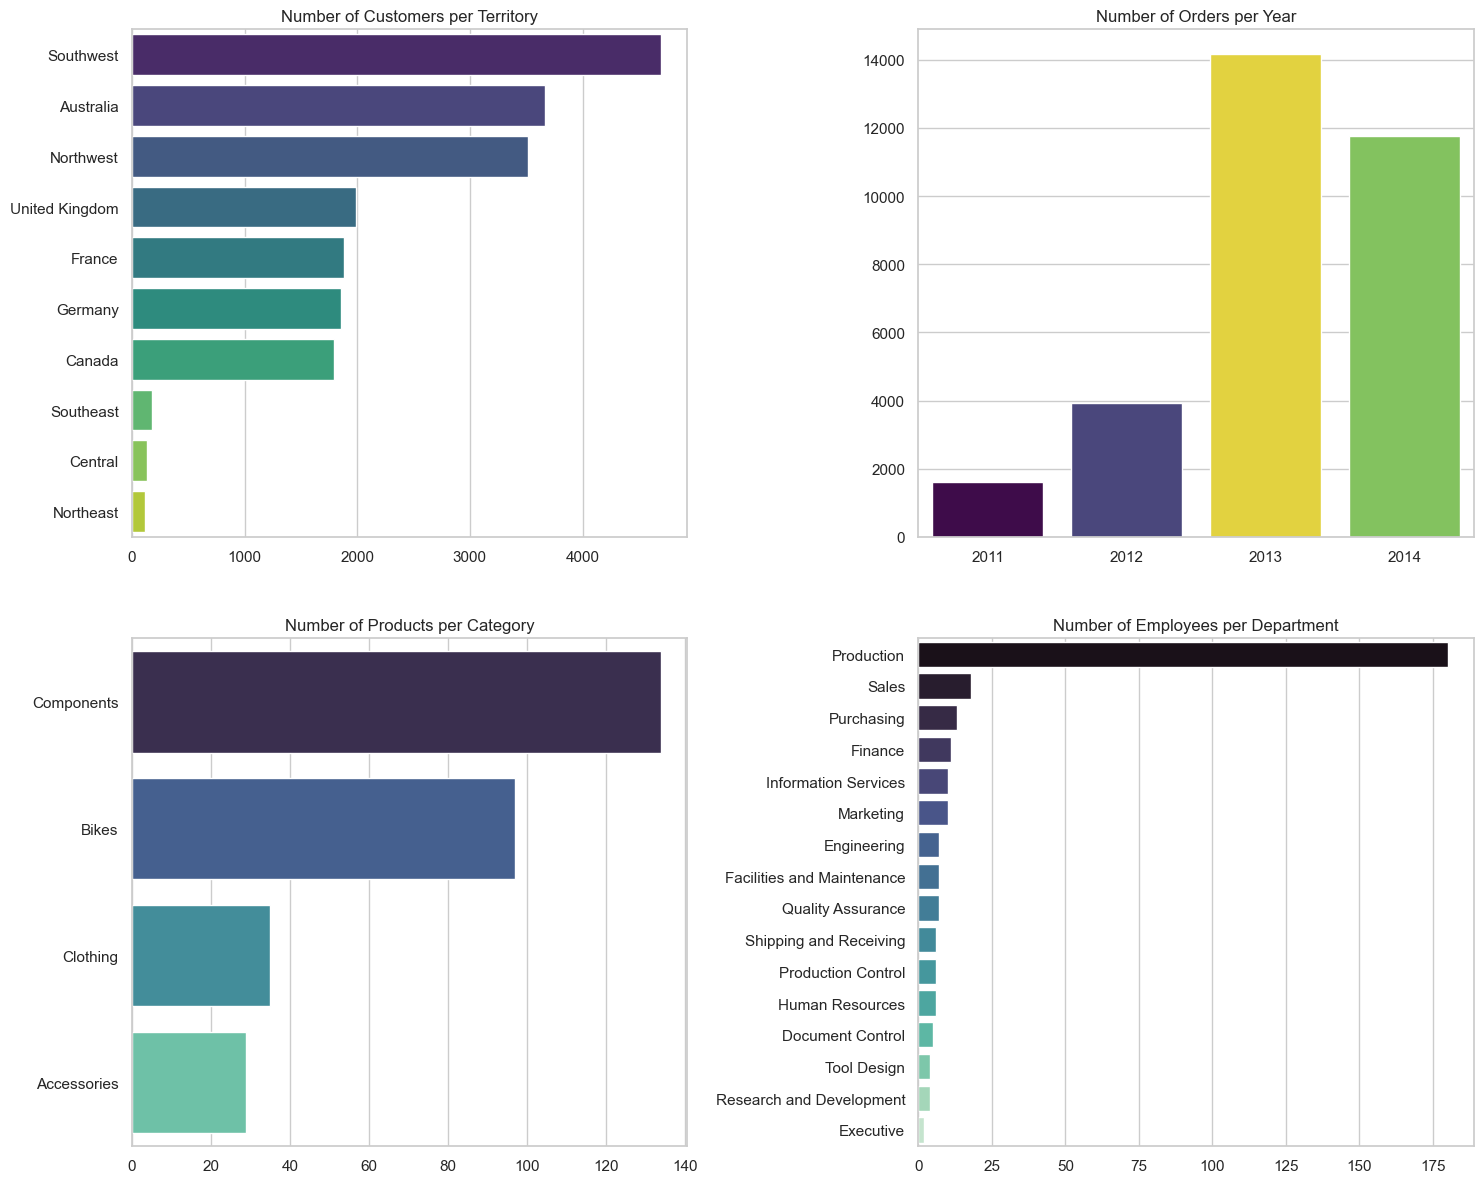

In [144]:
# Visualization setup
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

plots = [
    {
        'data': df_customers_per_territory.sort_values('CustomerCount', ascending=False),
        'x': 'TerritoryName', 'y': 'CustomerCount', 'palette': 'viridis','title': 'Number of Customers per Territory','ax': axes[0, 0]
    },
    {
        'data': df_orders_per_year.sort_values('NumberOfOrders'),
        'y': 'Year', 'x': 'NumberOfOrders', 'palette': 'viridis', 'title': 'Number of Orders per Year', 'ax': axes[0, 1],
    },
    {
        'data': df_products_per_category.sort_values('ProductCount', ascending=False),
        'x': 'CategoryName', 'y': 'ProductCount', 'palette': 'mako', 'title': 'Number of Products per Category', 'ax': axes[1, 0]
    },
    {
        'data': df_employees_per_department.sort_values('NumberOfEmployees', ascending=False),
        'x': 'DepartmentName', 'y': 'NumberOfEmployees', 'palette': 'mako', 'title': 'Number of Employees per Department', 'ax': axes[1, 1]
    }
]

# Plot all graphs
for plot in plots:
    ax = plot['ax']
    sns.barplot(
        data=plot['data'], y=plot['x'], x=plot['y'], palette=plot['palette'], hue=plot['x'], legend=False, ax=plot['ax']
    )
    plot['ax'].set_title(plot['title'])
    plot['ax'].set_xlabel('')
    plot['ax'].set_ylabel('')
        
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.show()


## Descriptive Summary

The AdventureWorks2022 database is divided into several important schemas, each representing different parts of the business:

- **Production:** Contains data about manufacturing and products, including product details, categories and inventory management.

- **Sales:** Contains all sales transactions, customer orders, and financial data. 

- **Person:** Stores information about customers, contacts and personal details.

- **HumanResources:** Manages employee data, job titles, departments and other personnel information.

- **Purchasing:** Contains details about purchases, suppliers and purchase orders.

The charts above illustrate customer distribution, sales trends, product portfolio, and workforce structure, corresponding to the main schemas in the database. Overall, this overview provides a solid foundation for understanding the key aspects of AdventureWorks2022’s business data. To deepen these insights, the subsequent statistical analysis will focus on the number of orders per customer, aiming to better understand customer engagement and purchasing behavior through inferential statistics.
